In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/akshay/proj/ephys_analysis')

from myinit import *
from load_neural_data import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['axes.titleweight'] = 'bold'

sns.set(font='Helvetica', style='ticks')
matplotlib.rcParams['text.color'] = [0,0,0]
sns.set_palette(sns.husl_palette(h=0.6))
colors = sns.color_palette()

In [6]:
from scipy.spatial.distance import cosine as cosdist
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def softmin(x, exponent=1.0):
    """
    Compute the softmin of vector x with an optional exponent.
    
    Parameters:
    x (array-like): Input vector.
    exponent (float): The exponent to be applied to each element before softmin. Default is 1.0.
    
    Returns:
    numpy.ndarray: Softmin result.
    """
    exp_neg_x = np.exp(-exponent * np.array(x))
    return exp_neg_x / np.sum(exp_neg_x)


def zeroshot_linkingmodel(feats, behavdf, img_fns_unique, dist = cosdist, softmax=False):

    choices = []
    for i in range(len(behavdf)):
        if behavdf['sample'].values[i] not in img_fns_unique or behavdf['choice0'].values[i] not in img_fns_unique or behavdf['choice1'].values[i] not in img_fns_unique:
            choices.append(np.nan)
            continue
        sample_feat = np.squeeze(feats[img_fns_unique == behavdf['sample'].values[i],:])
        choice0_feat = np.squeeze(feats[img_fns_unique == behavdf['choice0'].values[i],:])
        choice1_feat = np.squeeze(feats[img_fns_unique == behavdf['choice1'].values[i],:])
        # print(choice1_feat.shape)
        if softmax:
            choices.append(softmin([cosdist(sample_feat, choice0_feat),
                                 cosdist(sample_feat, choice1_feat)], exponent=100)[1])
        else:
            choices.append(np.argmin([cosdist(sample_feat, choice0_feat),
                                     cosdist(sample_feat, choice1_feat)]))
    return choices

def biasedsample_linkingmodel(feats, behavdf, img_fns_unique, dist = cosdist, train_size=0.8,
                              n_iters=1000, sample_size=25):
    nRows = len(behavdf)
    shuff_idx = np.random.permutation(nRows)
    train_idx, test_idx = shuff_idx[:int(nRows*train_size)], shuff_idx[int(nRows*train_size):]

    train_df, test_df = behavdf.loc[train_idx].reset_index(), behavdf.loc[test_idx].reset_index()

    results = {'sample': [], 'shapeacc_train': [], 'shapeacc_test': []}
    for i in range(n_iters):
        sample = np.random.choice(feats.shape[1], (sample_size,))
        
        train_choices = zeroshot_linkingmodel(feats[:,sample], train_df, img_fns_unique)
        test_choices = zeroshot_linkingmodel(feats[:,sample], test_df, img_fns_unique)

        results['sample'].append(sample)
        results['shapeacc_train'].append(np.nanmean(train_choices))
        results['shapeacc_test'].append(np.nanmean(test_choices))
    return results


def decode_utf(np_str_array):
    return np.array([x.decode('utf-8') for x in np_str_array])

In [3]:
behav_df = pd.read_parquet('data/human-behavior-data_proc.parquet')
data_sty = load_from_hdf5('data/objaverse-shapenet-stylized_ephys-data_2024.h5')
features = load_from_hdf5('features/features_objaverseshapenet-stylized_1000pcs.h5')

In [7]:
# run zero-shot linking model on behavioral data
thresh=0.1
sess = data_sty['baby1_240117-240419']
model_choices = {}
model_behav = behav_df[['trial_id', 'stim_set', 'sample', 'sample_categ', 'sample_object', 'sample_texture',
                        'choice0', 'choice1', 'tasktype', 'response']].copy().rename(columns={'response': 'behavior'})

modelnames = []
sessnames = []

modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 'resnext50-32x4d_fc', 'inception-v3_avgpool', 
               'vit-huge-p14_lhs', 'vit-mae-huge_lhs', 'dinov2-giant_lhs', 'clip-large-p14_lhs', ]
img_fns_unique = np.array([os.path.splitext(os.path.basename(x))[0] for x in decode_utf(sess['repavg']['stimulus_name'])])
for modelname in tqdm(modellayers):
    model_choices[modelname] = zeroshot_linkingmodel(features[modelname], behav_df, img_fns_unique, softmax = False)
    model_behav[modelname] = model_choices[modelname]
    modelnames.append(modelname)

for si, sess_name in tqdm(enumerate(data_sty), total=len(data_sty)):
    resp_peak = data_sty[sess_name]['repavg']['response_peak']
    img_fns_unique = np.array([os.path.splitext(os.path.basename(x))[0] for x in decode_utf(data_sty[sess_name]['repavg']['stimulus_name'])])
    
    brain_areas = data_sty[sess_name]['neuron_metadata']['brain_area']
    sc = data_sty[sess_name]['neuron_metadata']['reliability']
    if type(brain_areas[0])==bytes:
        brain_areas = np.array([x.decode('utf-8') for x in brain_areas])
    uareas = np.unique(brain_areas)
    for ai, area in enumerate(uareas):
        avgr = resp_peak[:, (brain_areas==area)*(sc>thresh)]
        if avgr.shape[1]<=1: continue
        model_choices[sess_name+'_'+area] = zeroshot_linkingmodel(avgr, behav_df, img_fns_unique, softmax=False)
        model_behav[sess_name+'_'+area] = model_choices[sess_name + '_' + area]
        sessnames.append(sess_name + '_' + area)
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:35<00:00, 10.59s/it]


In [20]:
# run biased sample linking model on behavioral data
# get only texcol vs categ trials
behavdf = behav_df[behav_df['tasktype']=='texcolvscateg'].reset_index(drop=True).copy()
n_iters=50
sample_size=25

biasedsample_results = {}

# run on monkey brains
for sess_name in tqdm(data_sty.keys()):
    resp_peak = data_sty[sess_name]['repavg']['response_peak']
    img_fns_unique = np.array([os.path.splitext(os.path.basename(x))[0] for x in decode_utf(data_sty[sess_name]['repavg']['stimulus_name'])])
    brain_areas = data_sty[sess_name]['neuron_metadata']['brain_area']
    sc = data_sty[sess_name]['neuron_metadata']['reliability']
    if type(brain_areas[0])==bytes:
        brain_areas = np.array([x.decode('utf-8') for x in brain_areas])
    uareas = np.unique(brain_areas)
    for ai, area in enumerate(uareas):
        avgr = resp_peak[:, (brain_areas==area)*(sc>thresh)]
        if avgr.shape[1]<=1: continue
        biasedsample_results[sess_name+'_'+area] = biasedsample_linkingmodel(avgr, behavdf, img_fns_unique,
                                                                                 train_size=0.75, n_iters=n_iters, sample_size=sample_size)
# run on DNN models
sess = data_sty['baby1_240117-240419']
img_fns_unique = np.array([os.path.splitext(os.path.basename(x))[0] for x in decode_utf(sess['repavg']['stimulus_name'])])
for modelname in tqdm(modelnames):
    if modelname == 'imagenames': continue
    biasedsample_results[modelname] = biasedsample_linkingmodel(features[modelname], behavdf, img_fns_unique, 
                                                                train_size=0.75, n_iters=n_iters, sample_size=sample_size)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:33<00:00, 57.33s/it]


/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

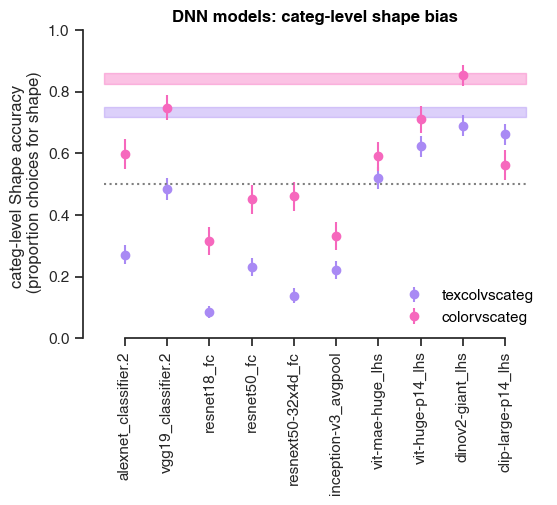

In [13]:
tasktypes = ['texcolvscateg', 'colorvscateg']

colors = sns.color_palette()
colors = [colors[1], colors[2]]
fig, ax = plt.subplots(figsize=(6,4))
gb = model_behav.groupby('tasktype')[['behavior'] + modelnames + sessnames]

for ti, tasktype in enumerate(tasktypes):
    
    Y = gb.agg(np.nanmean).loc[tasktype, modelnames]
    Yerr = 2*gb.agg(SE).loc[tasktype, modelnames]

    ax.fill_between([0-.5, len(modelnames)-.5], 
                    gb.agg(np.nanmean).loc[tasktype, 'behavior'] - gb.agg(SE).loc[tasktype, 'behavior'],
                    gb.agg(np.nanmean).loc[tasktype, 'behavior'] + gb.agg(SE).loc[tasktype, 'behavior'],
                    color=colors[ti], alpha=0.4,
                   )
    b0 = sns.color_palette('tab10')[0]
    ax.errorbar(np.arange(len(Y)), Y.loc[modellayers], yerr=Yerr.loc[modellayers], color=colors[ti], marker='o', ls='none',
               label = tasktype)
ax.set_xticks(np.arange(len(Y)))
ax.set_xticklabels(modellayers, rotation=90);
ax.plot([-.5, len(modelnames)-.5], [0.5, 0.5], ls=':', color='gray')
ax.set_ylim(0, 1.0)
level = tasktypes[0].split('vs')[1]
ax.set_title(f'DNN models: {level}-level shape bias')
ax.set_ylabel(f'{level}-level Shape accuracy \n (proportion choices for shape)')
ax.legend(frameon=False)
sns.despine(trim=True)
# fig.savefig(f'{figdir}/dnns/DNN-behavior_cueconflict_zeroshot-accuracy_{level}.pdf', bbox_inches='tight', transparent=True)

In [38]:
biasedsample_results['alexnet_classifier.2']['shapeacc_test']

AttributeError: 'list' object has no attribute 'shape'

/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


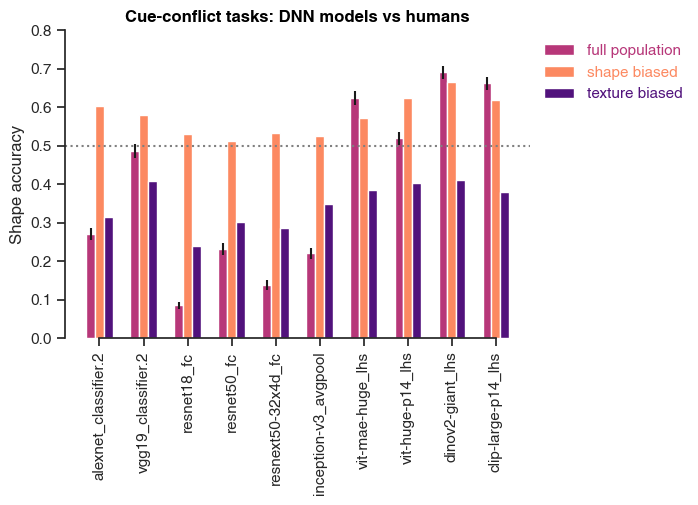

In [64]:
tasktypes = ['texcolvscateg', 'colorvscateg']
colors = sns.color_palette('magma', 3)

fig, ax = plt.subplots(figsize=(6,4))
gb = model_behav.groupby('tasktype')[['behavior'] + modelnames + sessnames]

tasktype = 'texcolvscateg'

# Plot uncued
Y = gb.agg(np.nanmean).loc[tasktype, modelnames]
Yerr = gb.agg(SE).loc[tasktype, modelnames]
ax.bar(np.arange(len(modelnames))-.2, Y.loc[modelnames], 
            yerr = Yerr.loc[modelnames], color=colors[1], label = 'full population', width=.2,)

# Plot cued
Y_tex, Y_shape = [], []
for mi, modellayer in enumerate(modellayers):
    res = biasedsample_results[modellayer]
    texturiest_idx = np.argmin(res['shapeacc_test'])
    shapiest_idx = np.argmax(res['shapeacc_test'])
    Y_tex.append(res['shapeacc_test'][texturiest_idx])
    Y_shape.append(res['shapeacc_test'][shapiest_idx])

ax.bar(np.arange(len(modellayers)), Y_shape, color=colors[2], width=.2, label='shape biased' )
ax.bar(np.arange(len(modellayers))+.2, Y_tex, color=colors[0], width=.2, label = 'texture biased' )
# ax.errorbar(np.arange(len(modelnames)), Y_shape, color=colors[2],ls='None', marker='o', label='shape biased subpopulation')
# ax.errorbar(np.arange(len(modelnames))+.2, Y_tex, color=colors[0],ls='None', marker='o', label = 'texture biased subpopulation')

ax.set_xticks(np.arange(len(Y)))
ax.set_xticklabels(modellayers, rotation=90);
ax.axhline(0.5, ls=':', color='gray')
ax.set_ylim(0, 0.8)
ax.set_title('Cue-conflict tasks: DNN models vs humans')
ax.set_ylabel('Shape accuracy')
ax.legend(frameon=False, bbox_to_anchor=[1,1], labelcolor = [colors[1], colors[2], colors[0]])
sns.despine(trim=True)

fig.savefig(f'figures/paper_figures/DNN_biased-sample-readout.pdf', bbox_inches='tight', transparent=True)

/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


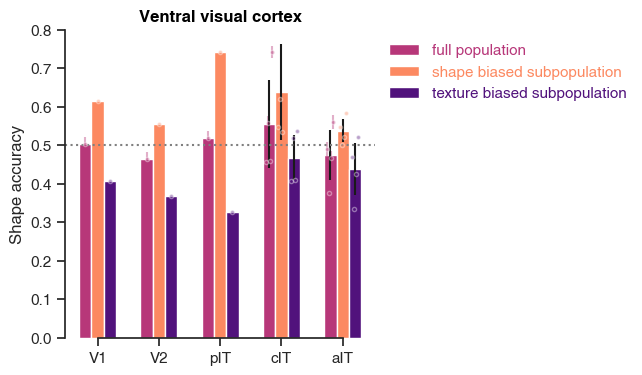

In [66]:
gb = model_behav.groupby('tasktype')[['behavior'] + modelnames + sessnames]

fig, ax = plt.subplots(figsize=(4,4))
sess_names = {'V1': ['paul_240405-240416_V1'],
              'V2': ['paul_240405-240416_V2'],
              'pIT': ['paul_240405-240416_pIT'],
              'cIT': ['baby1_240117-240419_cIT', 'sweetie_20240117-20240419_l_cIT', 
                      'louie_20240117-20240419_l_cIT', 'paul_20240405-20240416_l_cIT', ],
              'aIT': ['baby1_240117-240419_aIT', 'red_20240117-20240419_l_aIT', 
                      'baby1_20240117-20240419_r_aIT', 'anthony_20240117-20240419_r_aIT',],
                      # 'jordan_20240117-20240121_l_aIT']
             }

xoff = np.linspace(-.15, .15, len(tasktypes))
tasktype = 'texcolvscateg'    

colors = sns.color_palette('magma', 3)

# Plot uncued
Y = gb.agg(np.nanmean).loc[tasktype, sessnames]
Yerr = gb.agg(SE).loc[tasktype, sessnames]

for si, area in enumerate(sess_names):
    Ys = Y.loc[sess_names[area]]
    xshifts = np.linspace(-.05, .05, len(sess_names[area])) if len(sess_names[area])>1 else 0
    ax.errorbar(si+xshifts-.2, Ys, yerr=Yerr.loc[sess_names[area]], ls='none', color=colors[1], marker='.', alpha=0.4, markeredgecolor='white')
ax.bar(np.arange(len(sess_names))-.2, [np.nanmean(Y.loc[sess_names[area]]) for area in sess_names], yerr=[SE(Y.loc[sess_names[area]]) for area in sess_names], 
       color=colors[1], width=.2, label = 'full population')

# Plot best shape acc
for ai, area in enumerate(sess_names):
    # sess_names[area]
    xshifts = np.linspace(-.05, .05, len(sess_names[area])) if len(sess_names[area])>1 else [0]
    Y_tex, Y_shape = [], []
    for si, sess_name in enumerate(sess_names[area]):
        res = biasedsample_results[sess_name]
        texturiest_idx = np.argmin(res['shapeacc_test'])
        shapiest_idx = np.argmax(res['shapeacc_test'])

        ax.errorbar(ai+xshifts[si]+.2, res['shapeacc_test'][texturiest_idx], ls='none', color=colors[0], marker='.', alpha=0.4, markeredgecolor='white')
        ax.errorbar(ai+xshifts[si], res['shapeacc_test'][shapiest_idx], ls='none', color=colors[2], marker='.', alpha=0.4, markeredgecolor='white')
        Y_tex.append(res['shapeacc_test'][texturiest_idx])
        Y_shape.append(res['shapeacc_test'][shapiest_idx])
    ax.bar(ai, np.nanmean(Y_shape), yerr=SE(np.array(Y_shape)), color=colors[2], width=.2, label='shape biased subpopulation' if ai==0 else None)
    ax.bar(ai+.2, np.nanmean(Y_tex), yerr=SE(np.array(Y_tex)), color=colors[0], width=.2, label = 'texture biased subpopulation' if ai==0 else None)

ax.set_xticks(np.arange(len(sess_names)), sess_names.keys())
ax.legend(frameon=False, bbox_to_anchor=[1,1], labelcolor = [colors[1], colors[2], colors[0]])
ax.set_ylabel('Shape accuracy')
ax.set_title('Ventral visual cortex')
ax.axhline(0.5, ls=':', color='gray')
ax.set_ylim(0., .8)

sns.despine(trim=True)
fig.savefig(f'figures/paper_figures/VVC_biased-sample-readout.pdf', bbox_inches='tight', transparent=True)